In [1]:
import sys
print(sys.version)


3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]


# Set Up & Get Data


## Install Dependencies & Set up

In [2]:
!pip install labelme tensorflow==2.10.0 opencv-python matplotlib albumentations

In [84]:
import tensorflow as tf
import os

In [85]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [86]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Collect data using opencv

In [6]:
!pip list 


Package                      Version
---------------------------- -----------
absl-py                      2.0.0
albumentations               1.3.1
anyio                        3.5.0
argon2-cffi                  20.1.0
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
brotlipy                     0.7.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           2.0.4
colorama                     0.4.6
coloredlogs                  15.0.1
cryptography                 39.0.1
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.1
defusedxml                   0.7.1
entrypoints                  0.4
fastjsonschema               2.16.2
filelock                     3.12.2
flatbuffers                  23.5.2

In [7]:
!pip install opencv-contrib-python

     -------------------------------------- 44.8/44.8 MB 189.1 kB/s eta 0:00:00


In [87]:
import os
import time
import uuid #uniform unique identifier
import cv2

In [89]:
img_path=os.path.join('data','images')
num_img=30

In [92]:
cap = cv2.VideoCapture(0)

if cap.isOpened():
    current_frame = 0
    
    for image_num in range(num_img):
        print('Collecting image {}'.format(image_num))
        ret, frame = cap.read()
        
        # Check if the frame is empty
        if not ret or frame is None:
            print('Error: Unable to capture frame')
            break
        
        image_name = os.path.join(img_path, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(image_name, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        current_frame += 1

cap.release()
cv2.destroyAllWindows()


        

## Annotate images with Labelme

In [94]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: C:\Users\ASUS\.labelmerc


# Review Dataset and build image loading function

# Import TF & dependencies

In [95]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

## Limit GPU memmory growth


In [96]:
# Avoid oom error by setting GPU's memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    

In [97]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load images into tf Data pipeline

In [102]:
# Load an example image
image_path = '886eddd8-686e-11ee-af7c-ec2e98c85294.jpg.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Check the shape of the loaded image
image_shape = image.shape

# Print the number of channels
num_channels = image_shape[-1]  # The last dimension represents the number of channels
print(f"Number of channels in the image: {num_channels}")

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: 886eddd8-686e-11ee-af7c-ec2e98c85294.jpg.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]

In [103]:
import glob


# Define the directory containing your image files
image_dir = 'data/images/*.jpg'  # Use the appropriate file extension

# Use glob to get a list of all image file paths in the directory
image_paths = glob.glob(image_dir)



# Create a dataset of image paths
image_paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def load_image(X):
    byte_img = tf.io.read_file(X)
    img = tf.io.decode_jpeg(byte_img, channels=3)  # Set channels according to your images
    return img


In [104]:
image_paths_dataset = image_paths_dataset.shuffle(buffer_size=len(image_paths))
images_dataset = image_paths_dataset.map(load_image)

In [105]:
images_dataset.as_numpy_iterator().next()

array([[[225, 247, 245],
        [225, 247, 245],
        [223, 248, 245],
        ...,
        [210, 226, 223],
        [210, 226, 223],
        [209, 225, 222]],

       [[224, 246, 244],
        [224, 246, 244],
        [222, 247, 244],
        ...,
        [211, 227, 224],
        [210, 226, 223],
        [209, 225, 222]],

       [[224, 246, 243],
        [224, 246, 243],
        [222, 247, 243],
        ...,
        [209, 228, 224],
        [208, 227, 223],
        [207, 226, 222]],

       ...,

       [[175, 191, 191],
        [173, 191, 191],
        [173, 191, 191],
        ...,
        [113, 113, 113],
        [111, 111, 111],
        [110, 110, 110]],

       [[173, 191, 193],
        [172, 192, 191],
        [171, 191, 190],
        ...,
        [110, 108, 109],
        [108, 106, 107],
        [106, 104, 105]],

       [[172, 192, 193],
        [171, 191, 192],
        [171, 191, 190],
        ...,
        [104, 102, 103],
        [108, 104, 105],
        [109, 105, 106]]

In [106]:
type(images_dataset)

tensorflow.python.data.ops.dataset_ops.MapDataset

## View raw images with matplotlib

In [107]:
image_generator = images_dataset.batch(4).as_numpy_iterator()

In [108]:
plot_images = image_generator.next()

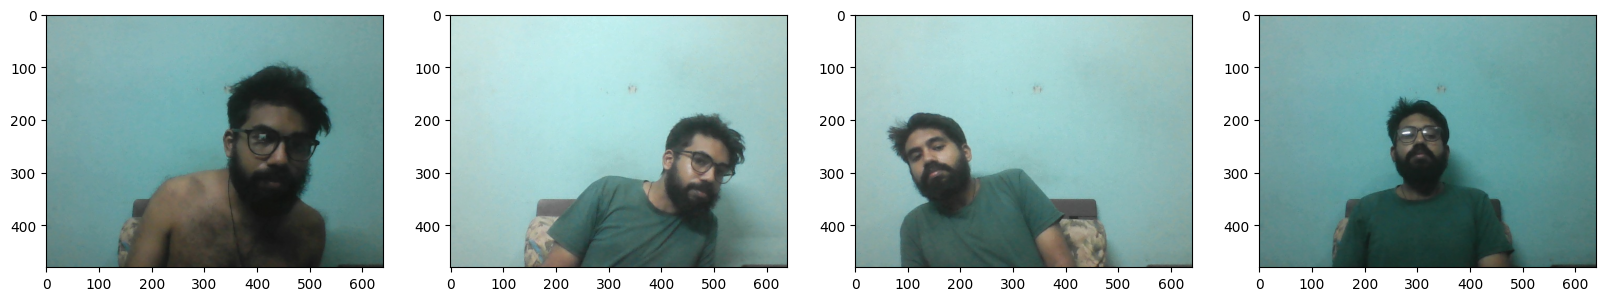

In [109]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()    

# Partition Unaugmented Data

## Manually split data into train, test and validation set

In [110]:
# train =63
# test = 14
# val = 13

## Move the matching labels

In [111]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        
        filename_without_extension, _ = os.path.splitext(file)
        
        filename =  filename_without_extension + '.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on images and labels using albumentations

## Setup Albumentation transform pipeline


In [4]:
!pip install --upgrade albumentations

In [112]:
import albumentations as alb

In [113]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## Load a test image and annotations 

In [127]:
img= cv2.imread(os.path.join('data','train','images','84c59a8c-686e-11ee-bb60-ec2e98c85294.jpg'))

In [128]:
with open(os.path.join('data', 'train', 'labels', '84c59a8c-686e-11ee-bb60-ec2e98c85294.json'), 'r') as f:
    label = json.load(f)

## Extract Coordinates and Rescale those to  match image resolution

In [129]:
cords= [0,0,0,0]
cords[0] = label['shapes'][0]['points'][0][0]
cords[1] = label['shapes'][0]['points'][0][1]
cords[2] = label['shapes'][0]['points'][1][0]
cords[3] = label['shapes'][0]['points'][1][1]

In [130]:
cords

[173.38541666666669, 96.77083333333331, 341.09375, 317.0833333333333]

In [131]:
cords= list(np.divide(cords, [640,480,640,480]))

In [132]:
cords


[0.2709147135416667, 0.20160590277777773, 0.532958984375, 0.6605902777777778]

## Apply augmentations

In [133]:
augmented = augmentor(image = img , bboxes = [cords], class_labels=['face'])

In [134]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

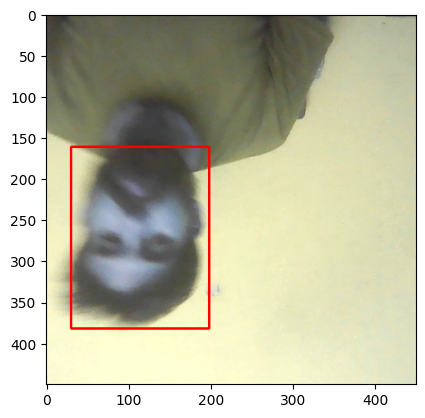

In [135]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                     (255,0,0), 2)
plt.imshow(augmented['image'])

# Build and Run augmentation pipeline

## Run augmentation pipeline

In [136]:


for partition in ['train', 'test', 'val']:
    for image_filename in os.listdir(os.path.join('data', partition, 'images')):
        image_path = os.path.join('data', partition, 'images', image_filename)
        img = cv2.imread(image_path)

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image_filename.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

                # Create directories if they don't exist
                output_image_dir = os.path.join('augmented_data', partition, 'images')
                os.makedirs(output_image_dir, exist_ok=True)

                output_label_dir = os.path.join('augmented_data', partition, 'labels')
                os.makedirs(output_label_dir, exist_ok=True)

                cv2.imwrite(
                    os.path.join(output_image_dir, f'{image_filename.split(".")[0]}.{x}.jpg'),
                    augmented['image'])

                annotation = {}
                annotation['image'] = image_filename

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(
                        os.path.join(output_label_dir, f'{image_filename.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


## Load augmented images to tensorflow dataset


In [137]:
train_images = tf.data.Dataset.list_files('augmented_data/train/images/*.jpg', shuffle=False)

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels as needed

    # Resize the image to (120, 120)
    img = tf.image.resize(img, (120, 120))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    return img

# Map the load_and_preprocess_image function to each file path
train_images = train_images.map(load_and_preprocess_image)


In [138]:
test_images = tf.data.Dataset.list_files('augmented_data/test/images/*.jpg', shuffle=False)

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels as needed

    # Resize the image to (120, 120)
    img = tf.image.resize(img, (120, 120))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    return img

# Map the load_and_preprocess_image function to each file path
test_images = test_images.map(load_and_preprocess_image)


In [139]:
val_images = tf.data.Dataset.list_files('augmented_data/val/images/*.jpg', shuffle=False)

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust channels as needed

    # Resize the image to (120, 120)
    img = tf.image.resize(img, (120, 120))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    return img

# Map the load_and_preprocess_image function to each file path
val_images = val_images.map(load_and_preprocess_image)


In [140]:
train_images.as_numpy_iterator().next()

array([[[0.8235907 , 0.91427696, 0.90496325],
        [0.8217524 , 0.91979164, 0.90802693],
        [0.8181372 , 0.9161765 , 0.9044118 ],
        ...,
        [0.8509804 , 0.9137255 , 0.9122549 ],
        [0.84816176, 0.9173407 , 0.9112745 ],
        [0.85061276, 0.9161152 , 0.9137255 ]],

       [[0.8127451 , 0.9112745 , 0.8995098 ],
        [0.8147059 , 0.9132353 , 0.9014706 ],
        [0.81170344, 0.9136642 , 0.9018995 ],
        ...,
        [0.8622549 , 0.9171569 , 0.9171569 ],
        [0.85882354, 0.9137255 , 0.9137255 ],
        [0.85294116, 0.9127451 , 0.9127451 ]],

       [[0.8115809 , 0.9135417 , 0.9096201 ],
        [0.8113358 , 0.9132966 , 0.909375  ],
        [0.81078434, 0.9127451 , 0.90882355],
        ...,
        [0.85882354, 0.9137255 , 0.9137255 ],
        [0.85882354, 0.9137255 , 0.9137255 ],
        [0.85606617, 0.9158701 , 0.9158701 ]],

       ...,

       [[0.2761642 , 0.38204658, 0.36243874],
        [0.25447303, 0.359375  , 0.34025735],
        [0.2887255 , 0

In [141]:
test_images.as_numpy_iterator().next()

array([[[0.8715686 , 0.972549  , 1.        ],
        [0.8745098 , 0.972549  , 1.        ],
        [0.8784314 , 0.96862745, 1.        ],
        ...,
        [0.8392157 , 0.96862745, 0.99607843],
        [0.8392157 , 0.96862745, 0.99607843],
        [0.8392157 , 0.96862745, 0.9911765 ]],

       [[0.8627451 , 0.9692402 , 0.9963848 ],
        [0.8697304 , 0.96862745, 0.99607843],
        [0.8784314 , 0.96862745, 1.        ],
        ...,
        [0.8352941 , 0.972549  , 0.99607843],
        [0.8391544 , 0.9686887 , 0.99607843],
        [0.8392157 , 0.96862745, 0.99852943]],

       [[0.85882354, 0.972549  , 0.99607843],
        [0.8646446 , 0.96954656, 0.99699754],
        [0.8784314 , 0.96862745, 1.        ],
        ...,
        [0.8352941 , 0.972549  , 0.99607843],
        [0.8352941 , 0.972549  , 0.99607843],
        [0.8367647 , 0.97107846, 0.99607843]],

       ...,

       [[0.6960784 , 0.78088236, 0.8401961 ],
        [0.70931375, 0.7916667 , 0.85833335],
        [0.7053309 , 0

In [142]:
val_images.as_numpy_iterator().next()

array([[[0.82683825, 0.95140934, 0.9318015 ],
        [0.82941175, 0.952451  , 0.93284315],
        [0.82941175, 0.952451  , 0.93284315],
        ...,
        [0.9137255 , 1.        , 0.99215686],
        [0.9189338 , 1.        , 0.99607843],
        [0.9158088 , 0.9990809 , 0.9976103 ]],

       [[0.81421566, 0.95      , 0.92696077],
        [0.8269608 , 0.952451  , 0.93284315],
        [0.8249387 , 0.96072304, 0.94552696],
        ...,
        [0.9127451 , 1.        , 0.99215686],
        [0.90974265, 0.99699754, 0.9891544 ],
        [0.90453434, 0.99626225, 0.99313724]],

       [[0.83125   , 0.94558823, 0.9295956 ],
        [0.831924  , 0.94650733, 0.93039215],
        [0.8387255 , 0.95637256, 0.9485294 ],
        ...,
        [0.8876838 , 1.        , 0.9927083 ],
        [0.8881127 , 1.        , 0.99313724],
        [0.8966299 , 1.        , 0.9972426 ]],

       ...,

       [[0.6612745 , 0.75085783, 0.72273284],
        [0.64846814, 0.7456495 , 0.7221201 ],
        [0.65006125, 0

# Prepare Labels

## Label loading function

In [143]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']],label['bbox']

## Load labels to tensorflow dataset

In [144]:


def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']],label['bbox']


# Create a dataset of label file paths
train_labels = tf.data.Dataset.list_files('augmented_data/train/labels/*.json', shuffle=False)

# Map the load_labels function to each label file path
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [145]:


def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']],label['bbox']

# Create a dataset of label file paths
test_labels = tf.data.Dataset.list_files('augmented_data/test/labels/*.json', shuffle=False)

# Map the load_labels function to each label file path
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [146]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']],label['bbox']

# Create a dataset of label file paths
val_labels = tf.data.Dataset.list_files('augmented_data/val/labels/*.json', shuffle=False)

# Map the load_labels function to each label file path
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [147]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2112, 0.3352, 0.5054, 0.7056], dtype=float16))

In [148]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4111, 0.3286, 0.7373, 0.7466], dtype=float16))

In [149]:
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.524 , 0.2866, 0.8374, 0.693 ], dtype=float16))

# Combine Label and Image samples

## Check partition lengths

In [150]:
len(train_images), len(train_labels),  len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

## Create final dataset

In [151]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [152]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [153]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [154]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

## View images and annotations

In [155]:
data_samples = train.as_numpy_iterator()

In [156]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


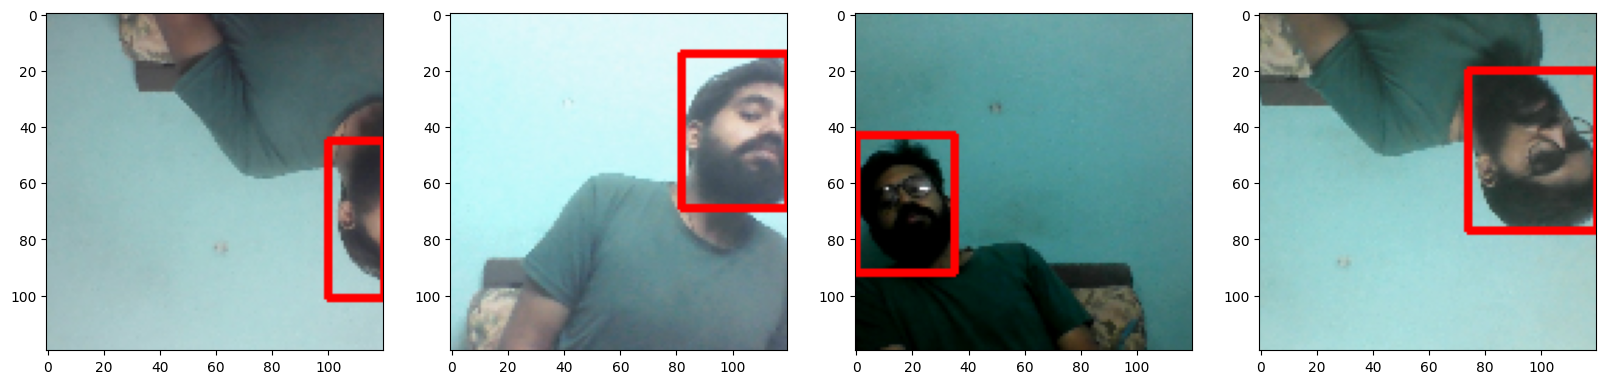

In [157]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)


# Build Deep Learning Model

## Import layers and base network

In [158]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## Download VGG-16

In [159]:
vgg = VGG16(include_top=False)

In [160]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Build instance of network

In [161]:

def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## Test Neural Network

In [162]:
facetracker = build_model()

In [163]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [164]:
X, y = train.as_numpy_iterator().next()


In [165]:
X.shape


(8, 120, 120, 3)

In [166]:
classes, cords = facetracker.predict(X)
classes, cords


1/1 [==============================] - 6s 6s/step


(array([[0.4735132 ],
        [0.517579  ],
        [0.5698319 ],
        [0.5470044 ],
        [0.477832  ],
        [0.5040566 ],
        [0.5278966 ],
        [0.52166635]], dtype=float32),
 array([[0.59403664, 0.69969964, 0.49452403, 0.5855504 ],
        [0.6701878 , 0.6541394 , 0.4069612 , 0.50451136],
        [0.6259803 , 0.65967643, 0.47547427, 0.5573349 ],
        [0.62706083, 0.6402107 , 0.5092352 , 0.5933828 ],
        [0.6855665 , 0.7413759 , 0.41615865, 0.5338684 ],
        [0.6024348 , 0.7487283 , 0.42559788, 0.5712995 ],
        [0.5533065 , 0.74935037, 0.44669795, 0.5729905 ],
        [0.66925484, 0.70168585, 0.5693943 , 0.5652954 ]], dtype=float32))

# Define Losses and Optimizers

## Define optimizer and LR

In [167]:
len(train)


473

In [168]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [169]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## Create Localization Loss and Classification Loss

In [170]:
def localization_loss(y_true, yhat):            
    delta_cord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_cord + delta_size

In [171]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test out Loss Metrics


In [172]:
localization_loss(y[1], cords)


<tf.Tensor: shape=(), dtype=float32, numpy=7.478408>

In [173]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.671468>

In [174]:
regressloss(y[1], cords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.478408>

# Train Neural Network

## Create Custom model class

In [178]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, cords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), cords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, cords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), cords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [179]:
model = FaceTracker(facetracker)

In [180]:
model.compile(opt, classloss, regressloss)

## Train

In [181]:
logdir='logs'

In [182]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [183]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 310s 171ms/step - total_loss: 0.1874 - class_loss: 0.0431 - regress_loss: 0.1659 - val_total_loss: 0.0054 - val_class_loss: 2.6042e-04 - val_regress_loss: 0.0053
Epoch 2/10
473/473 [==============================] - 66s 117ms/step - total_loss: 0.0489 - class_loss: 0.0113 - regress_loss: 0.0433 - val_total_loss: 0.0066 - val_class_loss: 9.7598e-04 - val_regress_loss: 0.0061
Epoch 3/10
473/473 [==============================] - 67s 119ms/step - total_loss: 0.0694 - class_loss: 0.0206 - regress_loss: 0.0591 - val_total_loss: 0.0766 - val_class_loss: 0.0127 - val_regress_loss: 0.0702
Epoch 4/10
473/473 [==============================] - 66s 121ms/step - total_loss: 0.0449 - class_loss: 0.0112 - regress_loss: 0.0394 - val_total_loss: 0.0084 - val_class_loss: 5.2305e-05 - val_regress_loss: 0.0083
Epoch 5/10
473/473 [==============================] - 65s 121ms/step - total_loss: 0.0286 - class_loss: 0.0085 - regress_loss: 0.0243 - val_tot

## 10.3 Plot performance

In [184]:
history.history

{'total_loss': [0.004213969223201275,
  0.007880019955337048,
  0.029812024906277657,
  0.004784706514328718,
  0.006856350693851709,
  0.0017945682629942894,
  0.005580524448305368,
  0.0019459830364212394,
  0.00261099636554718,
  0.005675322376191616],
 'class_loss': [0.0005763133522123098,
  0.00015179200272541493,
  0.014509414322674274,
  6.273732287809253e-05,
  2.3543905172118684e-06,
  3.1799681892152876e-05,
  0.00016355629486497492,
  8.284198702313006e-05,
  1.5616597011103295e-05,
  3.7820380384800956e-05],
 'regress_loss': [0.003925812430679798,
  0.007804123684763908,
  0.022557318210601807,
  0.00475333770737052,
  0.006855173502117395,
  0.0017786683747544885,
  0.005498746410012245,
  0.0019045619992539287,
  0.002603188157081604,
  0.005656412336975336],
 'val_total_loss': [0.005413991864770651,
  0.006620701868087053,
  0.07660204917192459,
  0.008367265574634075,
  0.008227134123444557,
  0.0056398967280983925,
  0.022958260029554367,
  0.011941718868911266,
  0.01

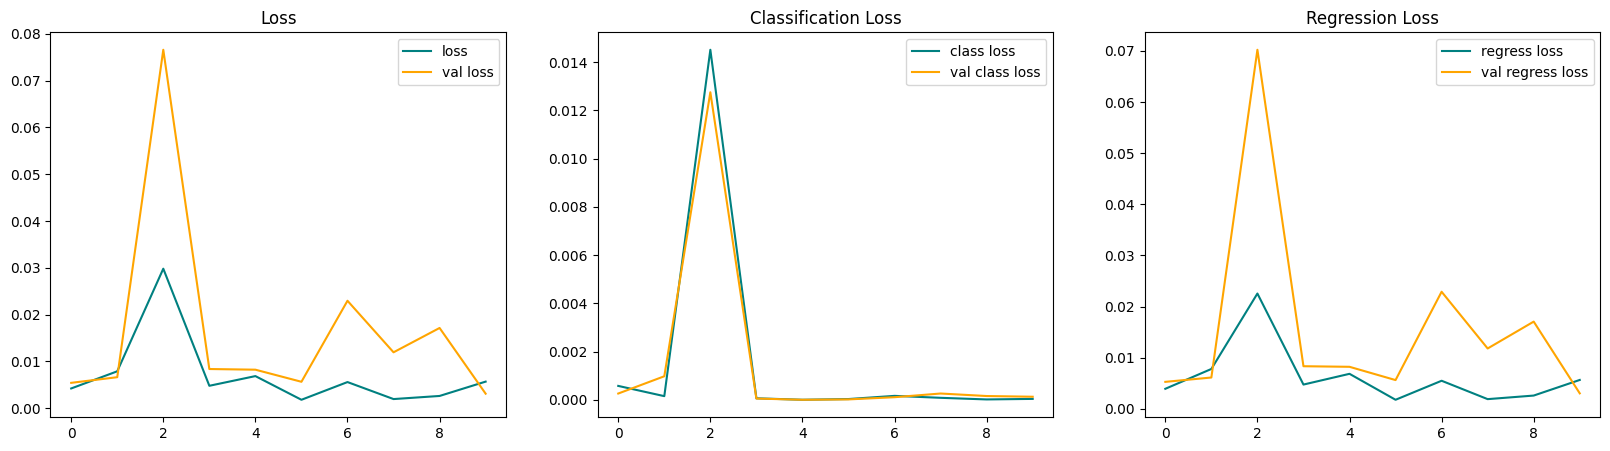

In [185]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()         

# Make Predictions

## Make Predictions on Test set

In [186]:
test_data = test.as_numpy_iterator()

In [187]:
test_sample = test_data.next()


In [188]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 84ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


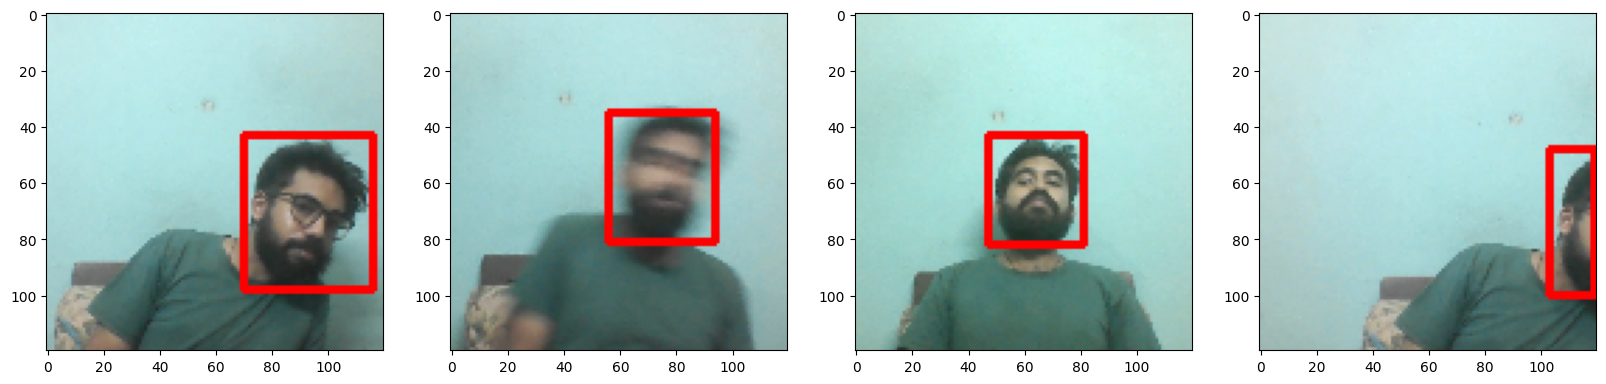

In [189]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_cords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_cords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_cords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save the model

In [190]:
from tensorflow.keras.models import load_model

In [191]:
facetracker.save('face_detection.h5')

In [192]:
facetracker = load_model('face_detection.h5')

## Real Time Detection

In [193]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
        

1/1 [==============================] - 0s 16ms/step
